### 售電資料取自台電106年,107年統計年報
### 歷史溫度資料取自行政院環保署歷史測站資料, 將每月資料以全部測站資料平均
##  -----------------------------------------------------------
## Step 1. 設定 Google Drive 連接 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive') # 點擊網址，選擇 Google 帳號登入，然後將授權碼貼回輸入框中

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ln -fs /content/gdrive/My\ Drive/Colab\ Notebooks/Datascience /app

### 步驟 2. 下載 cuDNN 檔案

1. 申請 Nvidia 帳號，申請網址為 http://bit.ly/2qfpOPj
2. 下載 `cudnn-10.0-linux-x64-v7.5.0.56.tgz`，下載網址為 
下載 cuDNN 檔案。下載網址為：http://bit.ly/2qfpOPj
3. 將下載的檔案 `cudnn-10.0-linux-x64-v7.5.0.56.tgz` 放到 google drive 的 `Colab Notebooks/Datascience/cuDNN/` 目錄下。

In [0]:
!tar -xzvf /app/cuDNN/cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

# 檢查是否安裝成功
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.5.0
cuda/lib64/libcudnn_static.a
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 5
#define CUDNN_PATCHLEVEL 0
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


## 步驟3. 載入相關模組, 讀取資料
### X0: 售電歷史資料, 2011~2018 每月平均售電量
### X10: 2011~2011 每月測站平均溫度

In [0]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from math import sqrt
from pandas import Series
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


In [0]:
dat = pd.read_csv('/app/input/2011-2018powerSaleTemp.csv', index_col=0)
(dat[0:5])
data = pd.read_csv('/app/input/x3x4Prosperity_indicator.csv', index_col=0)

In [0]:
print(dat.shape, data.shape)
print(dat.columns)
print(data.columns)

(96, 5) (104, 3)
Index(['year', 'Month', 'Power Gen. & Buy', 'Power Sale',
       'Temperature Month Average'],
      dtype='object')
Index(['月', '景氣對策信號(分)', '領先指標綜合指數(點)'], dtype='object')


In [0]:
X0 = np.array(list(dat['Power Sale']))
X10 = np.array(list(dat['Temperature Month Average']))
print(X0.shape,X10.shape)

(96,) (96,)


## 步驟4. 數據規一化及縮放

In [0]:
# Standardlized the dataset
X0 = Series(X0)
X10 = Series(X10)
print(X0[:5,])
print(X10[:5,])

0    14690
1    13246
2    16412
3    15016
4    16431
dtype: int64
0    15.300000
1    17.850000
2    17.685714
3    22.085714
4    25.135714
dtype: float64


In [0]:
# prepare data for normalization
x0 = X0.values
x0 = x0.reshape((len(x0), 1))
x10 = X10.values
x10 = x10.reshape((len(x10), 1))

In [0]:
# train the normalization
scaler = StandardScaler()
scaler = scaler.fit(x0)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
scaler1 = StandardScaler()
scaler1 = scaler1.fit(x10)
print('Mean: %f, StandardDeviation: %f' % (scaler1.mean_, sqrt(scaler1.var_)))

Mean: 17294.468750, StandardDeviation: 1821.567685
Mean: 23.866890, StandardDeviation: 4.308428


In [0]:
# normalize the dataset and print
X0_std = scaler.transform(x0)
print(X0_std[:5,])
X10_std = scaler.transform(x10)
print(X10_std[:5,])

[[-1.42979521]
 [-2.22251898]
 [-0.48445565]
 [-1.25082849]
 [-0.47402507]]
[[-9.48587795]
 [-9.48447806]
 [-9.48456825]
 [-9.48215275]
 [-9.48047837]]


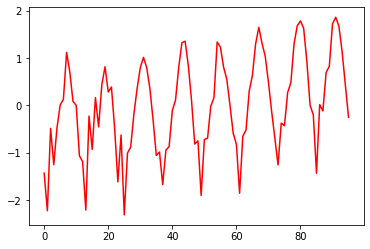

In [0]:
import matplotlib.pyplot as plt
plt.plot(X0_std[:,0],'r')

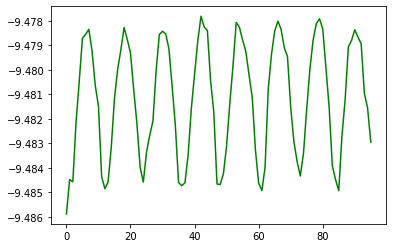

In [0]:
plt.plot(X10_std[:,0],'g')

## 步驟5. 首先以售電資料進行線性回歸分析

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
np.char.mod('%02d', np.array(list(dat['Month'])))   # 檢視欄位： Month 資料

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '01', '02', '03', '04', '05', '06', '07', '08', '09',
       '10', '11', '12', '01', '02', '03', '04', '05', '06', '07', '08',
       '09', '10', '11', '12', '01', '02', '03', '04', '05', '06', '07',
       '08', '09', '10', '11', '12', '01', '02', '03', '04', '05', '06',
       '07', '08', '09', '10', '11', '12', '01', '02', '03', '04', '05',
       '06', '07', '08', '09', '10', '11', '12', '01', '02', '03', '04',
       '05', '06', '07', '08', '09', '10', '11', '12'], dtype='<U2')

In [0]:
# 合併 年月欄位 當作 X 軸索引
a1 = np.array(list(dat['year']))
a2 = np.char.mod('%02d', np.array(list(dat['Month'])))
x = np.char.add(a1.astype(str),a2)
x = x.reshape(96,1)

In [0]:
#將資料集拆成： 80% 的訓練部份及 20% 檢驗部份
X_train, X_test, Y_train, Y_test = train_test_split(x, X0_std, test_size=0.2,random_state=3)

In [0]:
import time
from sklearn.linear_model import LinearRegression

In [0]:
# 建模
model = LinearRegression()

In [0]:
start = time.clock()
model.fit(X_train, Y_train)
print('elaspe: {0:.6f}'.format(time.clock()-start))

elaspe: 0.002978


In [0]:
#輸出結果
print(model.intercept_)
print(model.coef_)

[-242.15976845]
[[0.0012019]]


In [0]:
print(len(X_train))
X_train = X_train.astype(float)
X_test = X_test.astype(float)

76


In [0]:
# 評估
train_score = model.score(X_train, Y_train)
cv_score = model.score(X_test, Y_test)

In [0]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(model, X_train, Y_train, cv=10)
print(score)

[ 0.20588471  0.15967281 -0.46998272 -0.23025128 -0.24598162 -0.23307526
 -0.12958955  0.10942621 -0.10004155  0.05450494]


(array([1., 0., 0., 3., 0., 2., 0., 1., 1., 2.]),
 array([-0.46998272, -0.40239598, -0.33480923, -0.26722249, -0.19963575,
        -0.13204901, -0.06446226,  0.00312448,  0.07071122,  0.13829797,
         0.20588471]),
 <a list of 10 Patch objects>)

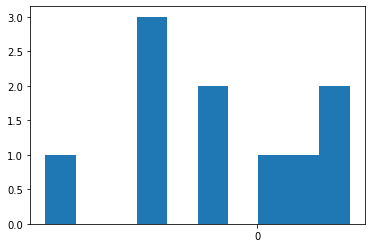

In [0]:
x =  np.arange(0, 100,10)
plt.xticks(x)
plt.hist(score)

In [0]:
print('train_score: {0:0.6f}; cv_score: {1:.6f}'.format(train_score, cv_score))

train_score: 0.078252; cv_score: 0.185143


## 步驟6. 採用多項式回歸分析

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [0]:
def polynomial_model(degree=1):
  polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
  linear_regression = LinearRegression(normalize=True)
  pipeline = Pipeline([("polynomial_features", polynomial_features),("linear_regression", linear_regression)])
  return pipeline

In [0]:
model = polynomial_model(degree=2)

start = time.clock()
model.fit(X_train, Y_train)

train_score = model.score(X_train, Y_train)
cv_score = model.score(X_test, Y_test)
print('elaspe: {0:.6f}; train_score: {1:0.6f}; cv_score: {2:.6f}'.format(time.clock()-start, train_score, cv_score))

elaspe: 0.006575; train_score: 0.078254; cv_score: 0.185680


degree:2	score:0.0782544054491483	mse loss:0.8734420197802063
degree:3	score:0.08018932275276425	mse loss:0.8716085007617601
degree:5	score:0.08319417466365664	mse loss:0.8687611164751348
degree:10	score:-1.2185972643174754	mse loss:2.102332885646777


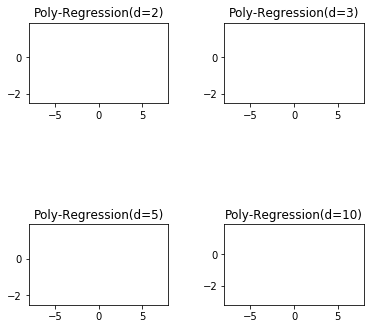

In [0]:
from sklearn.metrics import mean_squared_error
degrees = [2, 3, 5, 10]
models = []
msearry = []
for d in degrees:
   model = polynomial_model(degree=d)
   # 這裡會依次呼叫管道里的fit和transform(或者fit_transform),最後一個只調用fit
   model.fit(X_train, Y_train)
   train_score = model.score(X_train, Y_train)  # R2得分
   mse = mean_squared_error(Y_train, model.predict(X_train))  # MSE損失
   print("degree:{}\tscore:{}\tmse loss:{}".format(d, train_score, mse))
   models.append({"model": model, "degree": d, "MSE": mse})  # 訓練好的模型儲存下來

# 繪製不同degree的擬合結果,SubplotParams用於為子圖設定統一引數,這裡不用
#plt.figure(figsize=(12, 6), dpi=200, subplotpars=SubplotParams(hspace=3.0))
# fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
for i, mod in enumerate(models):
   fig = plt.subplot(2, 2, i + 1)
   plt.xlim(-8, 8)
   plt.title("Poly-Regression(d={})".format(mod["degree"]))
   plt.scatter(X_test, Y_test, s=5, c='b', alpha=0.5)
   plt.plot(X_test, mod["model"].predict(X_test), 'r-')
   # fig.tight_layout()
   msearry = np.append(msearry,mod["MSE"])
plt.show()


In [0]:
print(msearry.shape)
print("{}".format(msearry))

(4,)
[0.87344202 0.8716085  0.86876112 2.10233289]


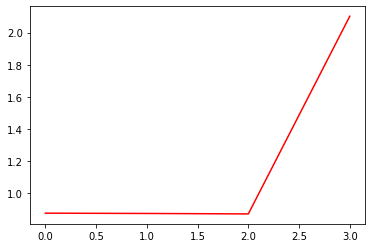

In [0]:
plt.plot(msearry,'r-')
plt.show()

In [0]:
min_degree = msearry.min()
print(min_degree)
# Get the indices of minimum element in numpy array
ndx = np.argmin(msearry)
print("The minimal mse for polynomial degree is: {}".format(degrees[ndx]))

0.8687611164751348
The minimal mse for polynomial degree is: 5


In [0]:
y_predict = mod["model"].predict(X_test)

In [0]:
print(y_predict.shape, Y_test.shape)

(20, 1) (20, 1)


In [0]:
for m in models:
  print("{},{},{}".format(m["model"],m["degree"],m["MSE"]))

Pipeline(memory=None,
         steps=[('polynomial_features',
                 PolynomialFeatures(degree=2, include_bias=False,
                                    interaction_only=False, order='C')),
                ('linear_regression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=True))],
         verbose=False),2,0.8734420197802063
Pipeline(memory=None,
         steps=[('polynomial_features',
                 PolynomialFeatures(degree=3, include_bias=False,
                                    interaction_only=False, order='C')),
                ('linear_regression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=True))],
         verbose=False),3,0.8716085007617601
Pipeline(memory=None,
         steps=[('polynomial_features',
                 PolynomialFeatures(degree=5, include_bias=False,
                                    in

In [0]:
best_model = polynomial_model(degree=5)
best_model.fit(X_train, Y_train)
y_predict = best_model.predict(X_test)
train_score = best_model.score(X_train, Y_train)  # R2得分
mse = mean_squared_error(Y_train, best_model.predict(X_train))  # MSE損失
print("degree:{}\tscore:{}\tmse loss:{}".format(5, train_score, mse))

degree:5	score:0.08319417466365664	mse loss:0.8687611164751348


Mean squared error: 0.98
Variance score: 0.15


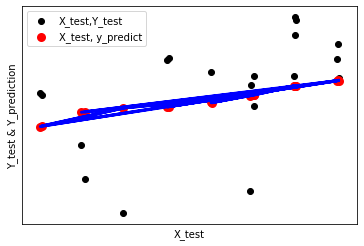

In [0]:
# The coefficients
#print('Coefficients: \n', model.coef())
# The mean squared error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, y_predict))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, y_predict))

# Plot outputs
plt.scatter(X_test, Y_test,  color='black', label='X_test,Y_test')
plt.scatter(X_test, y_predict, color='red', label='X_test, y_predict',linewidth=3)
plt.plot(X_test, y_predict, color='blue', linewidth=3)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.xlabel('X_test')
plt.ylabel('Y_test & Y_prediction')

plt.xticks(())
plt.yticks(())
plt.legend(loc='best') 
plt.show()

## 另一個評估

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [0]:
def PolynomialRegression(degree=2, **kwargs):
  return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

In [0]:
import numpy as np

In [0]:
def make_data(N, err=1.0, rseed=1):
  # 隨機抽樣數據
  rng = np.random.RandomState(rseed)
  X = rng.rand(N, 1) ** 2
  y = 10 -1./(X.ravel() + 0.1)
  if err >0:
    y += err * rng.randn(N)
      return X, y
      X, y = make_data(40)

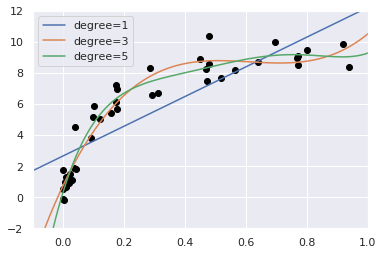

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  #設置圖形樣式

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
  y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
  plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
  plt.xlim(-0.1, 1.0)
  plt.ylim(-2, 12)
  plt.legend(loc='best')

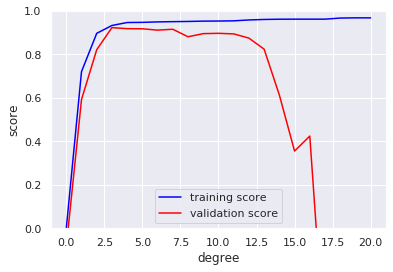

In [0]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
'polynomialfeatures__degree',
degree, cv=7)
plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

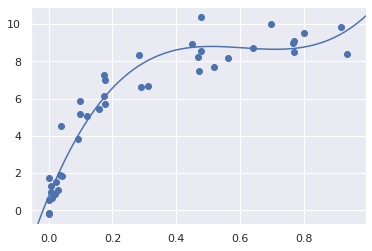

In [0]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

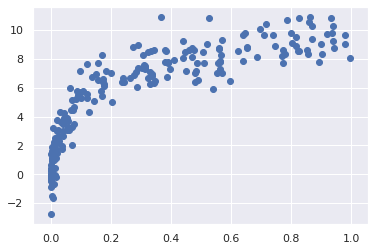

In [0]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

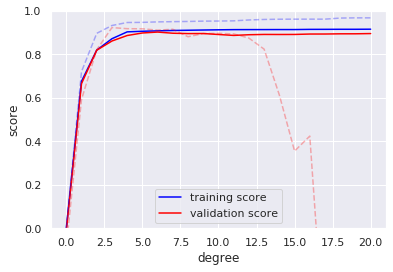

In [0]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
'polynomialfeatures__degree',
degree, cv=7)
plt.plot(degree, np.median(train_score2, 1), color='blue',
label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3,
linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3,
linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

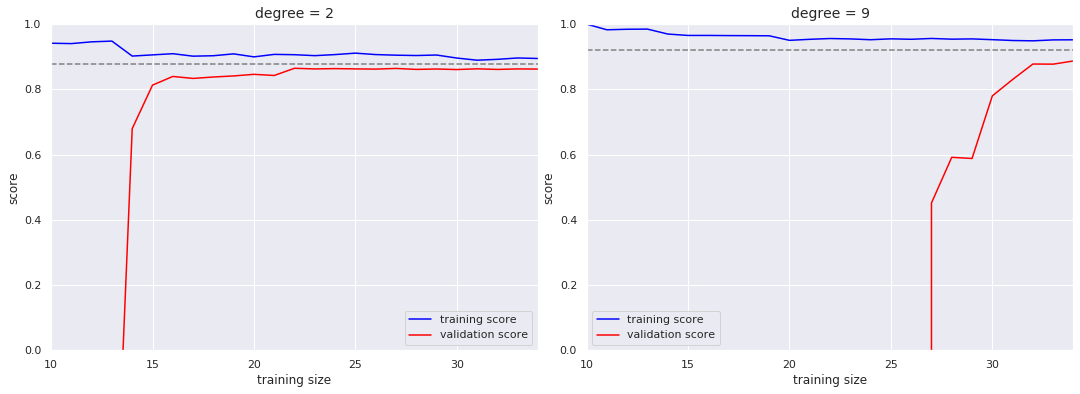

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
    X, y, cv=7,
    train_sizes=np.linspace(0.3, 1, 25))
    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color='gray',
        linestyle='dashed')
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

## 驗證實踐：網格搜索

In [0]:
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve, GridSearchCV
param_grid = {'polynomialfeatures__degree': np.arange(21),
'linearregression__fit_intercept': [True, False],
'linearregression__normalize': [True, False]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

In [0]:
grid.fit(X, y);

In [0]:
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

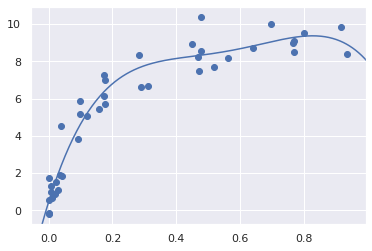

In [0]:
model = grid.best_estimator_
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

## 步驟7. 使用 SVM 分析

In [0]:
from sklearn.svm import SVC

In [0]:
# 溫度數據歸一化
mean1 = np.mean(X10, axis=0)
norm1 = X10 - mean1
# 溫度數據縮放
scope1 = np.max(norm1, axis=0) - np.min(norm1, axis=0)
norm1 = norm1 / scope1
norm1 = norm1.reshape(96,1)
norm1[:5]

array([[-0.5836324 ],
       [-0.40990977],
       [-0.42110199],
       [-0.1213453 ],
       [ 0.08644059]])

In [0]:
print(mean1,scope1)

23.86688988095238 14.678571428571427


In [0]:
# norm: power sale, norm1: temperature
a3 = np.array(list(dat['Month']))
# 數據歸一化
mean2 = np.mean(a3, axis=0)
norm2 = a3 - mean2
# 數據縮放
scope2 = np.max(norm2, axis=0) - np.min(norm2, axis=0)
norm2 = norm2 / scope2
norm2 = norm2.reshape(96,1)
norm2[:5]

array([[-0.5       ],
       [-0.40909091],
       [-0.31818182],
       [-0.22727273],
       [-0.13636364]])

In [0]:
XX = np.c_[norm1,norm2]
XX[:5]

array([[-0.5836324 , -0.5       ],
       [-0.40990977, -0.40909091],
       [-0.42110199, -0.31818182],
       [-0.1213453 , -0.22727273],
       [ 0.08644059, -0.13636364]])

In [0]:
from sklearn import preprocessing
from sklearn import utils

In [0]:
lab_enc = preprocessing.LabelEncoder()
training_scores_encoded = lab_enc.fit_transform(norm)
print(training_scores_encoded)

[ 8  1 31 10 32 48 53 80 69 50 45 12 11  2 38 17 54 33 63 74 57 61 30  6
 27  0 14 18 40 59 70 78 71 60 36 13 15  5 16 19 43 52 72 86 88 76 51 21
 22  3 23 25 44 55 87 82 73 66 47 28 20  4 26 29 58 67 83 90 85 79 65 41
 24  9 35 34 56 64 84 92 94 89 77 46 39  7 49 42 68 75 93 95 91 81 62 37]


In [0]:
clf = SVC(gamma='auto')
clf.fit(XX,training_scores_encoded) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

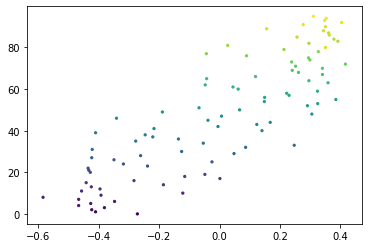

In [0]:
plt.scatter(XX[:,0],training_scores_encoded,c = clf.predict(XX),s = 5)

In [0]:
#錯誤率
y_predict = clf.predict(XX)
y_predict
res = abs(y_predict-training_scores_encoded).sum()/len(XX)
print(res)

0.13541666666666666


In [0]:
#準確率
1-res

0.8645833333333334

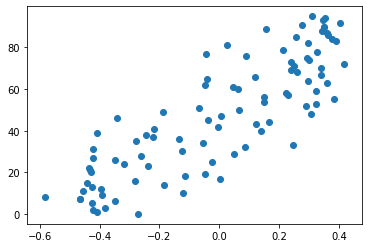

In [0]:
plt.scatter(XX[:,0],y_predict)

In [0]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

In [0]:
svc = SVC(kernel="linear", C=1)

rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
y = training_scores_encoded
print(y.shape)
rfe.fit(XX, y)
ranking = rfe.ranking_.reshape(-1,1)

(96,)


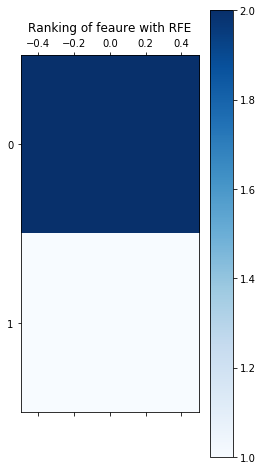

In [0]:
# Plot pixel ranking
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of feaure with RFE")
plt.show()